# Dependencias

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

from prophet import Prophet

import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm


from math import sqrt


Importing plotly failed. Interactive plots will not work.


# Dataset

In [3]:
data = pd.read_csv("./empleo_nacion/empleos_bsas_202303300007.csv")

In [4]:
data.tail()

,fecha,departamento,provincia,clase,puestos
1048599,2022-12-01,Zárate,Buenos Aires,"Actividades deportivas, recreativas y de entre...",150
1048600,2022-12-01,Zárate,Buenos Aires,Servicios de asociaciones,435
1048601,2022-12-01,Zárate,Buenos Aires,Reparación de computadoras y equipos de uso do...,6
1048602,2022-12-01,Zárate,Buenos Aires,Otros servicios personales,87
1048603,2022-12-01,Zárate,Buenos Aires,Otros sectores,3


In [5]:
# cambiamos el campo fecha de str a datetime
data["fecha"] = data.fecha.apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())

In [6]:
data_caba = data.loc[data.provincia == "CABA"].groupby(by=["fecha","provincia"]).sum().reset_index() 

# EDA

## Graficos generales

Text(0, 0.5, 'Puestos de trabajo')

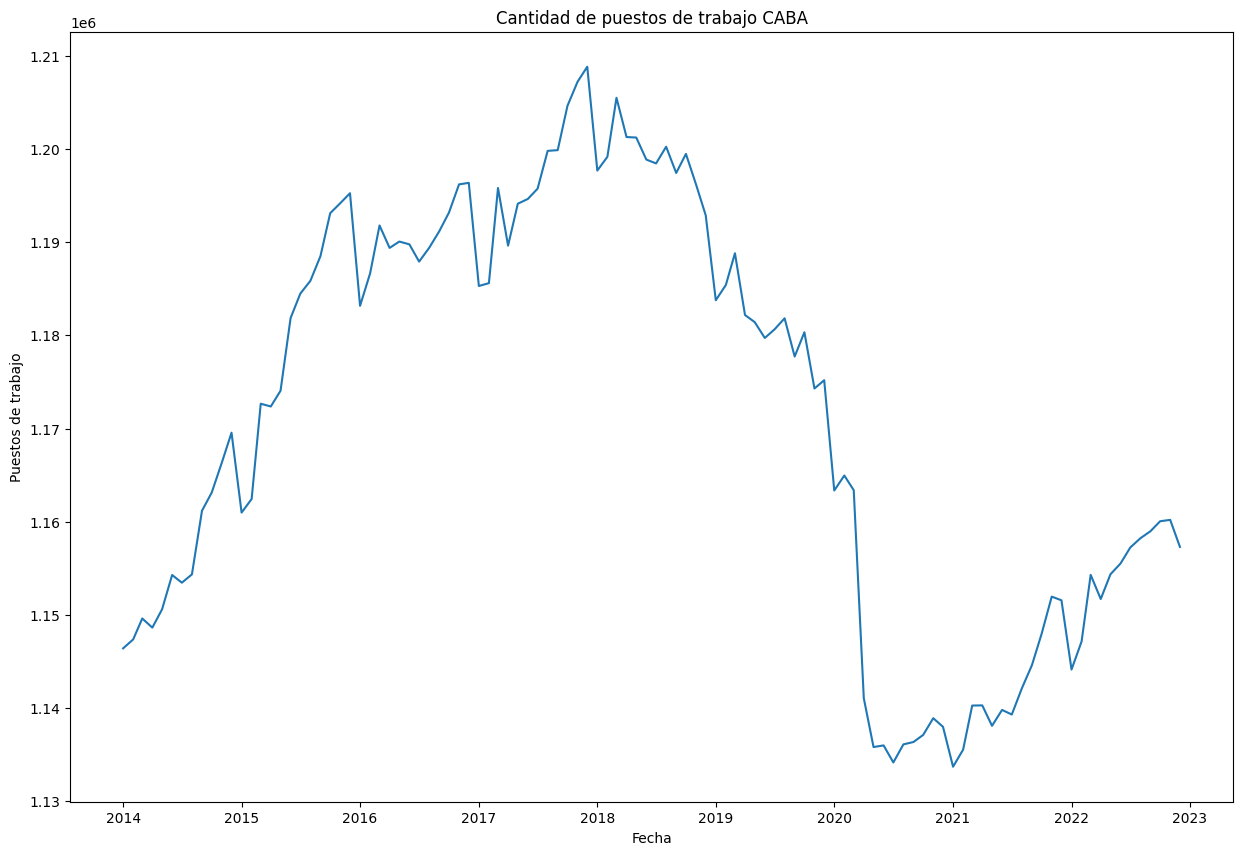

In [7]:
# Graficamos la serie de tiempo
plt.figure(figsize=(15, 10))
plt.plot(data_caba.fecha, data_caba.puestos)
plt.title('Cantidad de puestos de trabajo CABA')
plt.xlabel('Fecha')
plt.ylabel('Puestos de trabajo')

In [8]:
# Generamos subset de caba con el dato de cada sector o clase
data_caba_completo = data.loc[data.provincia == "CABA"]

In [9]:
# creamos una lista de sectores con mayor cantidad de puestos
top_sectore = data_caba_completo.groupby(by=["clase"]).sum().reset_index().sort_values("puestos", ascending = False).head(10).clase.to_list()

#Genero un subset para poder graficarlos
df_top_sectores = data_caba_completo[data_caba_completo.clase.isin(top_sectore)]

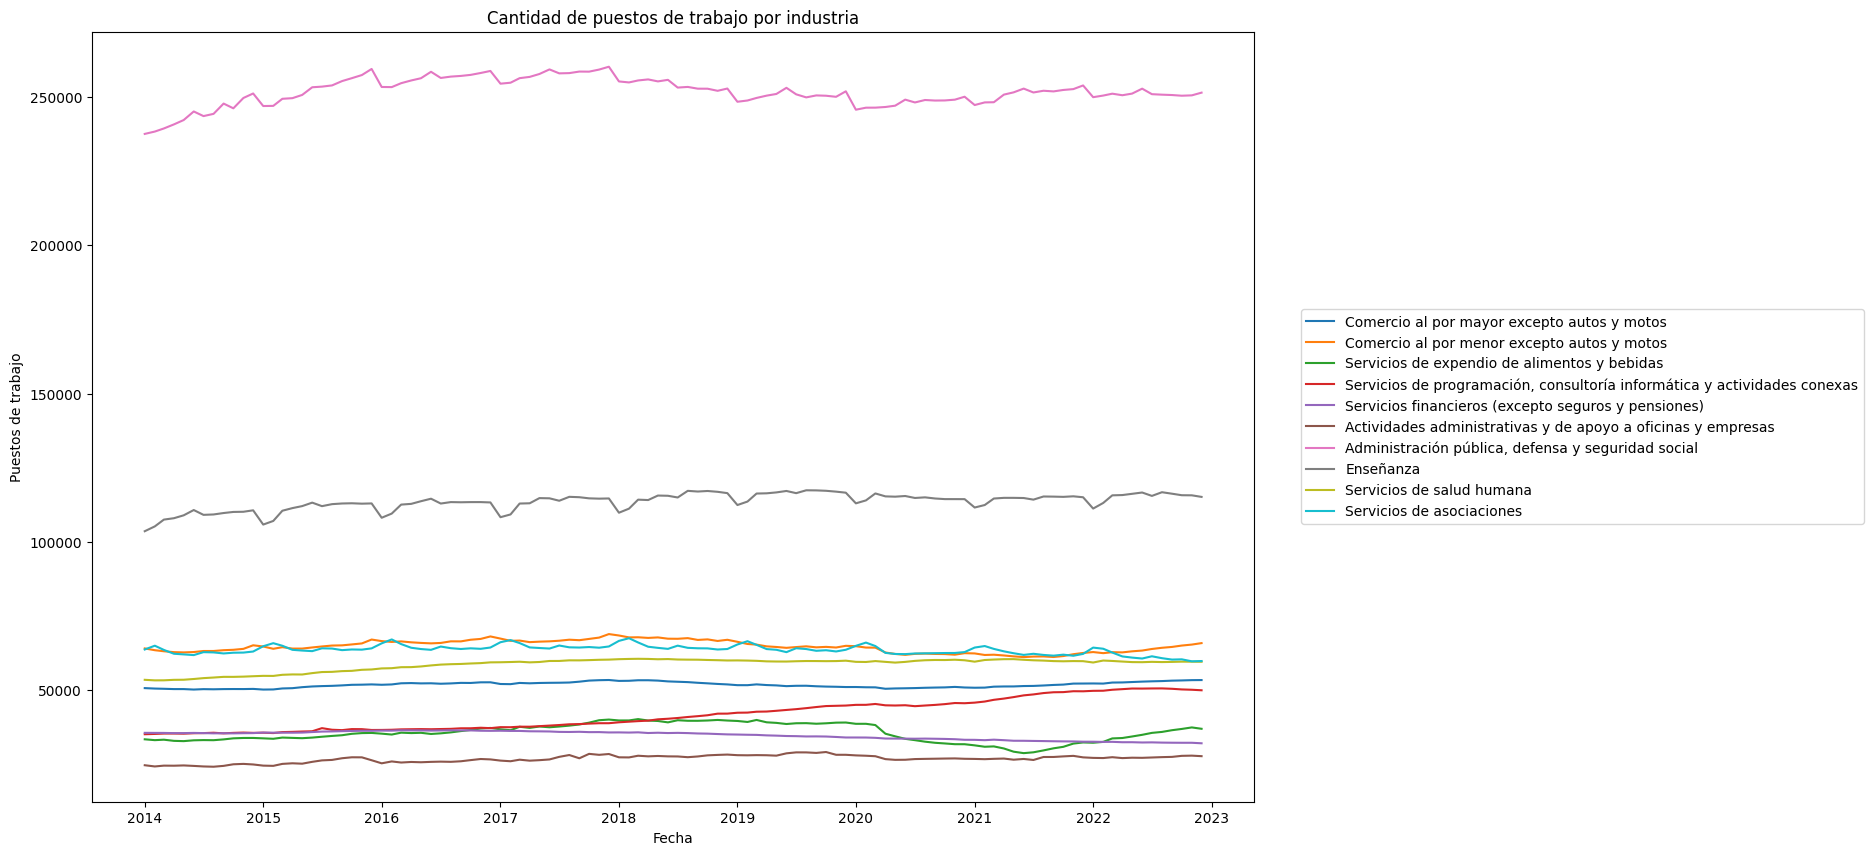

In [10]:
# Visualizar la serie de tiempo por sector
plt.figure(figsize=(15, 10))
sns.lineplot(x='fecha', y='puestos', hue='clase', data=df_top_sectores)
plt.title('Cantidad de puestos de trabajo por industria')
plt.xlabel('Fecha')
plt.ylabel('Puestos de trabajo')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.show()


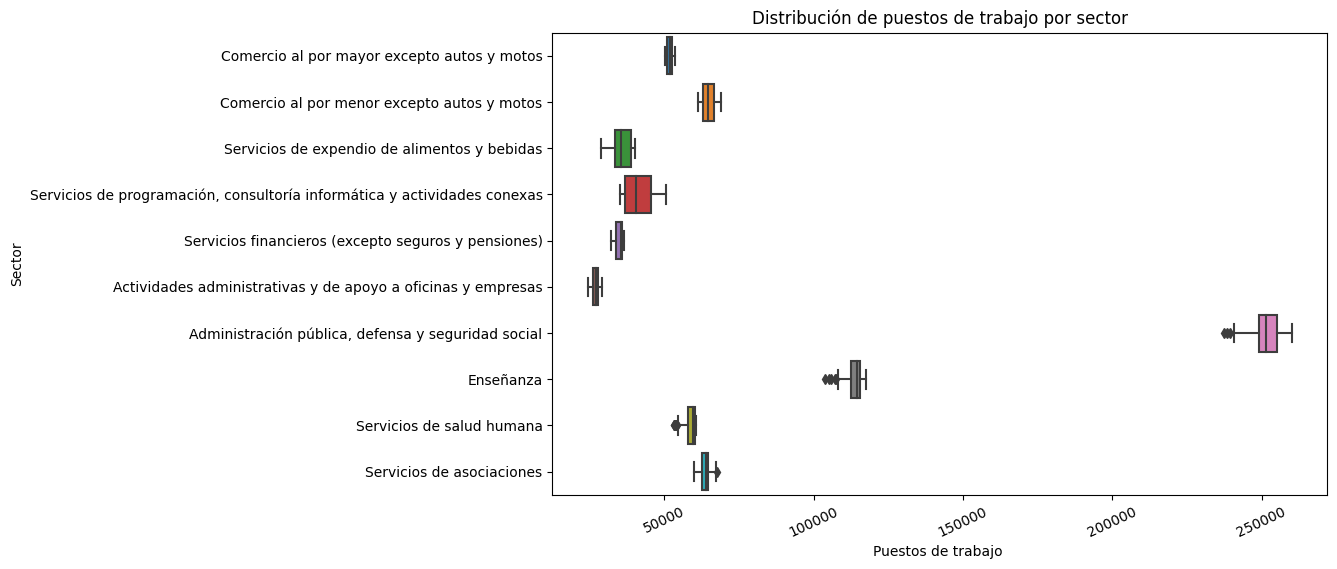

In [11]:
# Visualizo la distribución de puestos de trabajo por sector
plt.figure(figsize=(10, 6))
sns.boxplot(x='puestos', y='clase', data=df_top_sectores)
plt.title('Distribución de puestos de trabajo por sector')
plt.xlabel('Puestos de trabajo ')
plt.ylabel('Sector')
plt.xticks(rotation = 25) 
plt.show()

In [12]:
df_sector = df_top_sectores.groupby('clase').agg({'puestos': ['mean', 'median', 'min', 'max']})
df_sector.columns = ['Media', 'Mediana', 'Mínimo', 'Máximo']
df_sector

,Media,Mediana,Mínimo,Máximo
clase,,,,
Actividades administrativas y de apoyo a oficinas y empresas,26859.685185,26997.5,24220,29174
"Administración pública, defensa y seguridad social",251689.555556,251498.0,237558,260209
Comercio al por mayor excepto autos y motos,51805.685185,51841.0,50233,53456
Comercio al por menor excepto autos y motos,64761.879630,64687.5,61181,68936
Enseñanza,113544.064815,114431.0,103616,117412
Servicios de asociaciones,63653.518519,63888.0,59756,67543
Servicios de expendio de alimentos y bebidas,35644.342593,35558.0,28798,40274
"Servicios de programación, consultoría informática y actividades conexas",41638.805556,40520.0,35173,50622
Servicios de salud humana,58649.648148,59630.5,53335,60604


## Prophet

Vamos a utilizar prophet para evaluar las tendencias y estacionalidad de la serie temporal. Para ello crearemos tres modelos, el primero eliminando los ultimos tres años de la serie, para evitar los efectos de la pandemia (2020, 2021 y 2022), para el segundo dejaremos el la serie completa y en el ultimo utilizaremos el parametro holiday de prophet para indicar el periodo de 2020 y 2021 como un periodo con anomalias.

### Modelo 1 - Prophet sin 2020, 2021 y 2022

In [13]:
# Genero un nuevo subset para prophet, solo me tengo que quedar con dos columnas "ds" e "y"
# Inicialmente eliminamo la pandemia del modelo
data_prophet = data_caba.loc[data_caba["fecha"] < pd.to_datetime("2020-01-01").date() , ["fecha","puestos"]]
data_prophet.columns = ["ds", "y"]

16:50:23 - cmdstanpy - INFO - Chain [1] start processing
16:50:23 - cmdstanpy - INFO - Chain [1] done processing


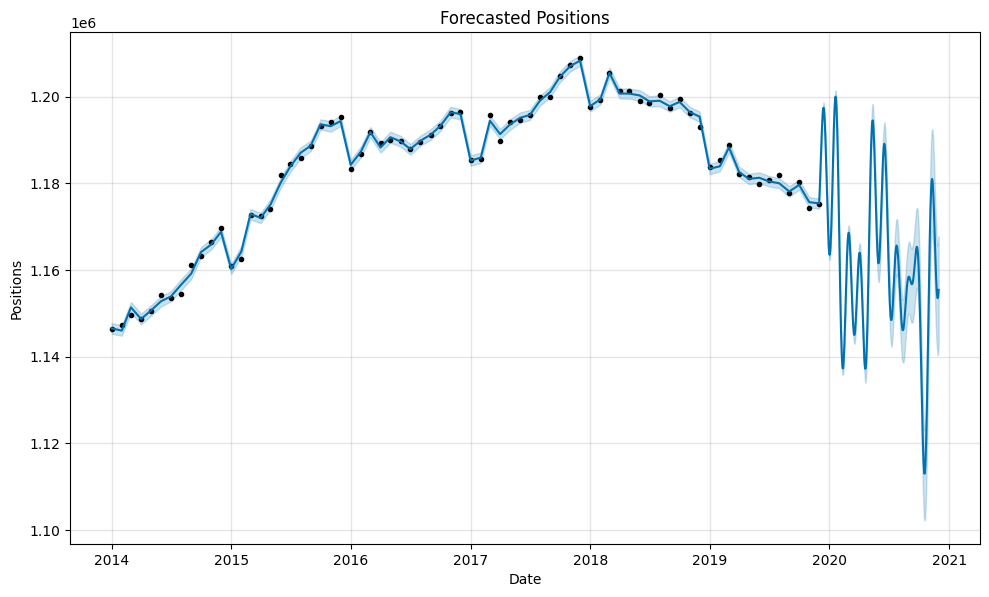

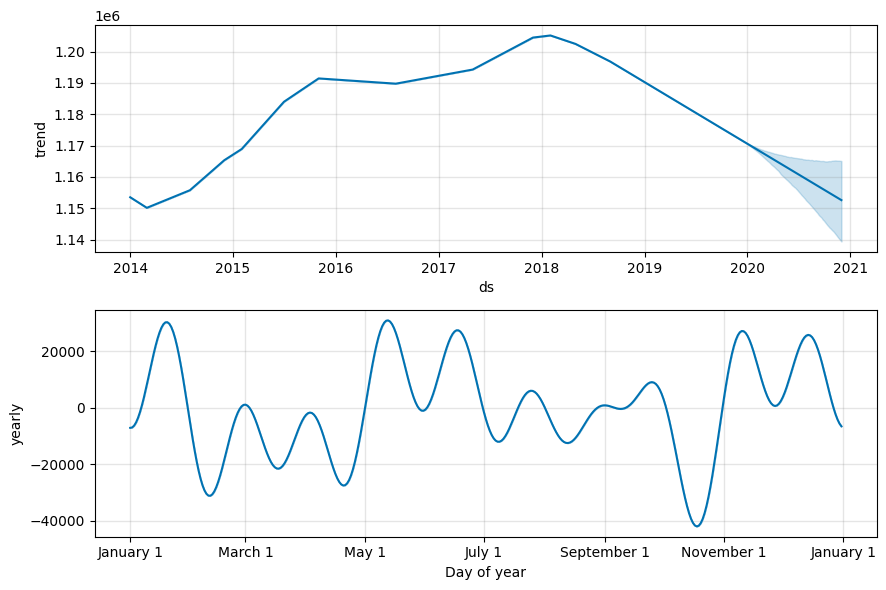

In [14]:
holidays = None  # Por ahora lo dejo en none

# Creo el modelo
modelo1 = Prophet(holidays=holidays)

# Ajusto el modelo a los datos
modelo1.fit(data_prophet)

# Genero el futuro
futuro1 = modelo1.make_future_dataframe(periods=365)  # Por ahora generamos 365 dias

# Hacemos la predicción
forecast1 = modelo1.predict(futuro1)

# Grafico la predicción
fig1 = modelo1.plot(forecast1)
plt.title('Forecasted Positions')
plt.xlabel('Date')
plt.ylabel('Positions')
plt.show()

# Grafico los componentes del modelo, como tenemos datos mensuales vamos a tener estacionalidad mensual y tendencia.
fig2 = modelo1.plot_components(forecast1)
plt.show()

### Modelo 2 - Prophet completo

In [15]:
# Ahora generemos el prophet pero con toda la serie completa
data_prophet = data_caba[["fecha","puestos"]]
data_prophet.columns = ["ds", "y"]

16:50:29 - cmdstanpy - INFO - Chain [1] start processing
16:50:29 - cmdstanpy - INFO - Chain [1] done processing


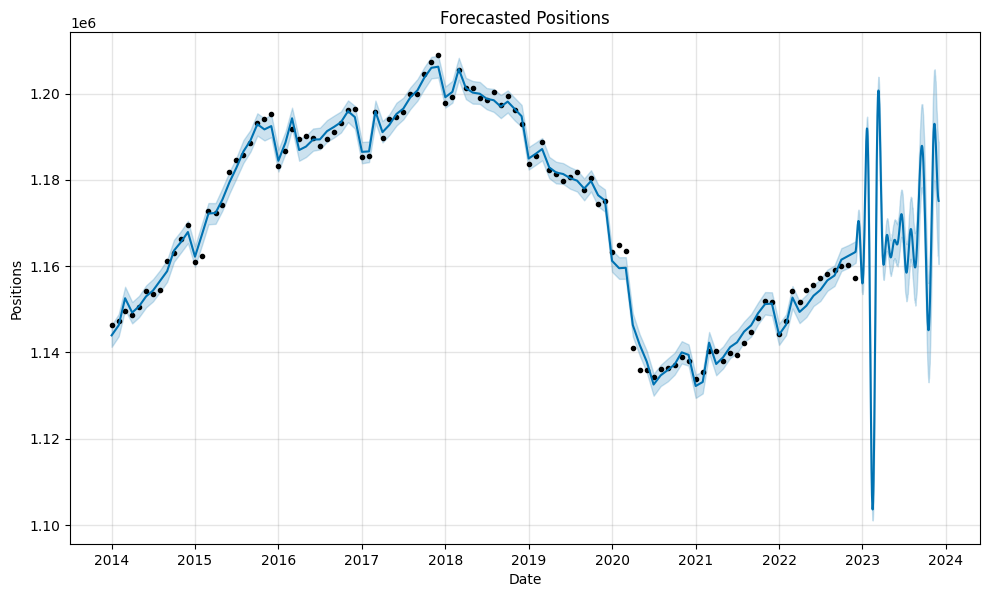

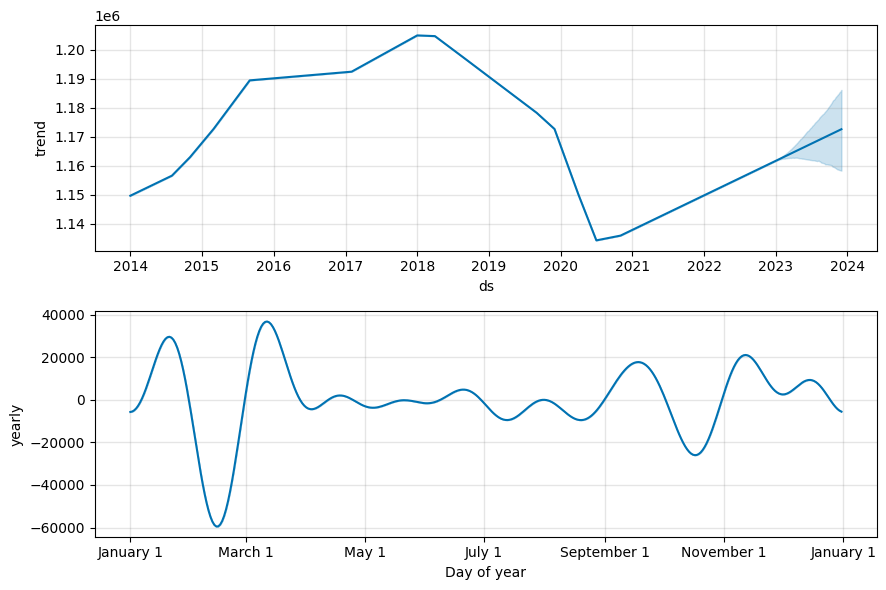

In [16]:
holidays = None  # Por ahora lo dejo en none

# Creo el modelo
modelo2 = Prophet(holidays=holidays)

# Ajusto el modelo a los datos
modelo2.fit(data_prophet)

# Genero el futuro
futuro2 = modelo2.make_future_dataframe(periods=365)  # Por ahora generamos 365 dias

# Hacemos la predicción
forecast2 = modelo2.predict(futuro2)

# Grafico la predicción
fig1 = modelo2.plot(forecast2)
plt.title('Forecasted Positions')
plt.xlabel('Date')
plt.ylabel('Positions')
plt.show()

# Grafico los componentes del modelo, como tenemos datos mensuales vamos a tener estacionalidad mensual y tendencia.
fig2 = modelo2.plot_components(forecast2)
plt.show()

### Modelo 3 - Holiday

In [17]:
# Ahora generemos el prophet pero con toda la serie completa
data_prophet = data_caba[["fecha","puestos"]]
data_prophet.columns = ["ds", "y"]

16:53:39 - cmdstanpy - INFO - Chain [1] start processing
16:53:39 - cmdstanpy - INFO - Chain [1] done processing


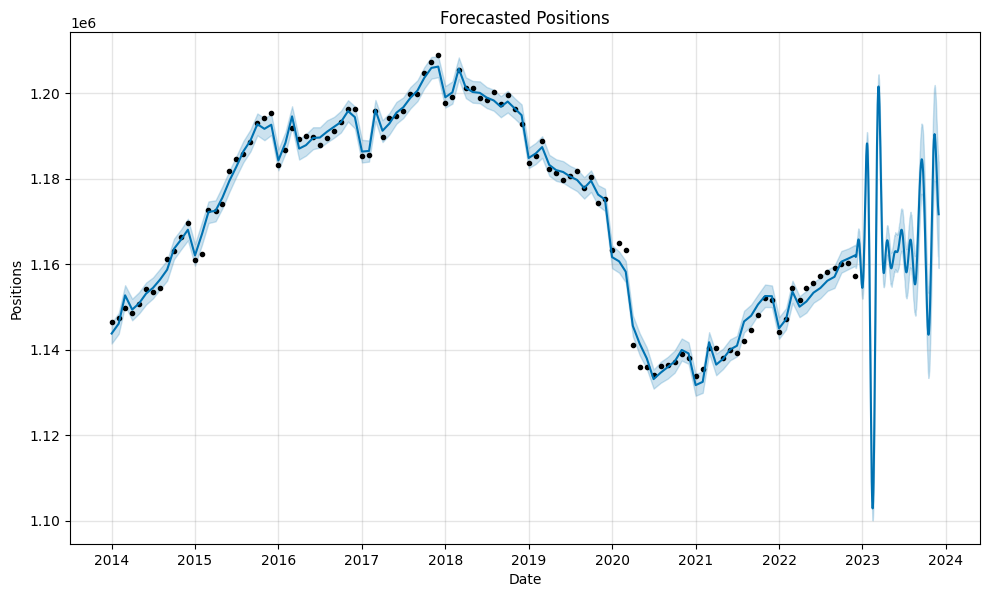

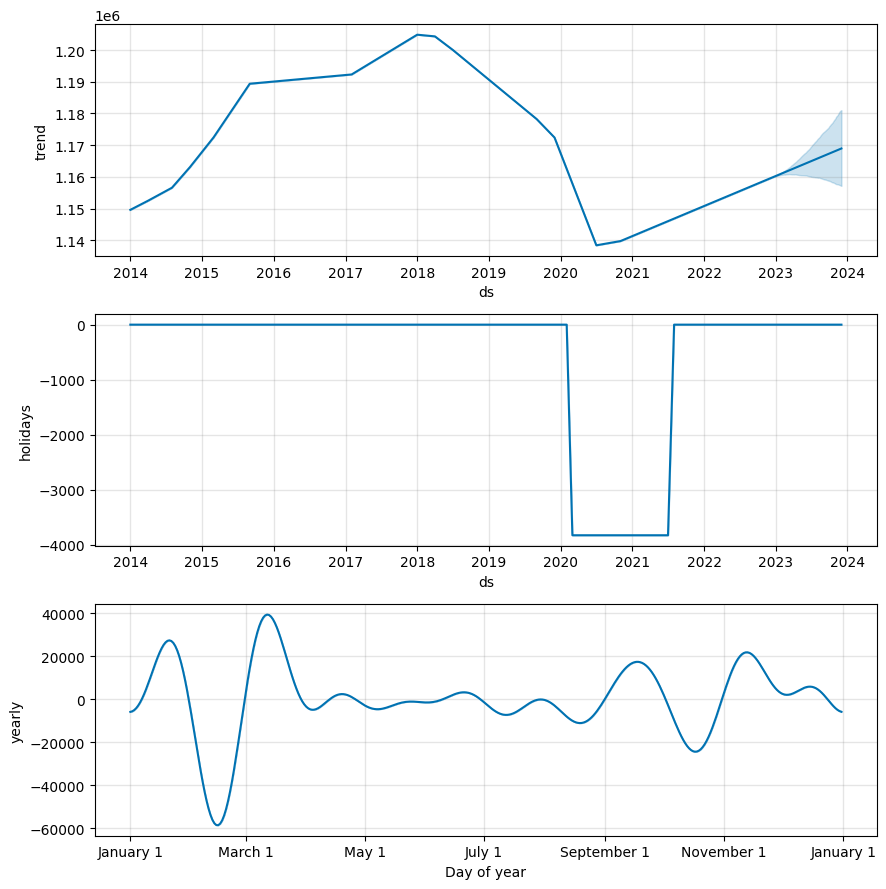

In [20]:
# how to set holiday parameter of a prophet model between 2020-03-01 and 2021-07-31 in python?
holidays = pd.DataFrame({
  'holiday': 'pandemia',
  'ds': pd.to_datetime(['2020-03-01', '2020-04-01', '2020-05-01',
                        '2020-06-01', '2020-07-01', '2020-08-01',
                        '2020-09-01', '2020-10-01', '2020-11-01',
                        '2020-12-01', '2021-01-01', '2021-02-01',
                        '2021-03-01', '2021-04-01', '2021-05-01', 
                        '2021-06-01', '2021-07-01'])  
})

# Creo el modelo
modelo2 = Prophet(holidays=holidays)

# Ajusto el modelo a los datos
modelo2.fit(data_prophet)

# Genero el futuro
futuro2 = modelo2.make_future_dataframe(periods=365)  # Por ahora generamos 365 dias

# Hacemos la predicción
forecast2 = modelo2.predict(futuro2)

# Grafico la predicción
fig1 = modelo2.plot(forecast2)
plt.title('Forecasted Positions')
plt.xlabel('Date')
plt.ylabel('Positions')
plt.show()

# Grafico los componentes del modelo, como tenemos datos mensuales vamos a tener estacionalidad mensual y tendencia.
fig2 = modelo2.plot_components(forecast2)
plt.show()

# Modelo

## ARIMA

In [143]:
# Generar subset con fecha y puestos
df = data_caba[["fecha","puestos"]]

# Genero set de validación 
# Me guardo el 2022 como futuro
test = df.loc[df["fecha"].between(pd.to_datetime("2022-01-01").date() , pd.to_datetime("2022-12-01").date())]

# Genero el set de prueba
df = df.loc[df["fecha"] < pd.to_datetime("2022-01-01").date()]

# Establecer la fecha como índice del DataFrame
df.set_index('fecha', inplace=True)

# Ordenar los datos por fecha
df.sort_index(ascending=True, inplace=True)


# Establecer la fecha como índice del DataFrame
test.set_index('fecha', inplace=True)

# Ordenar los datos por fecha
test.sort_index(ascending=True, inplace=True)

# Verificar si hay valores nulos
if df.isnull().sum().sum() > 0:
    # Manejar los valores nulos según tu estrategia (por ejemplo, rellenar con la media, la mediana, etc.)
    df.fillna(method='ffill', inplace=True)

# Extraer la columna de puestos como serie temporal
ts = df['puestos']

Los parametro de arima son la serie de tiempo y el orden compuesto tres parametros:
<br>

**P: numero de lags,**
<br>

**D: diferencia sobre la serie de tiempo,**

 > - 0 = Utiliza la estacionalidad de la serie de tiempo.
 > - 1 = Elimina tendencias lineales.
 > - 2 = Elimina tendencias cuadraticas.
 <br>

**Q: Tamaño de la media movil utilizada.**

In [62]:
# Ajustar un modelo ARIMA
arima = ARIMA(ts, order=(2, 0, 13))  
# Por lo visto en el prohphet la estacionalidad podria ser de ayuda, ademas no se detectan patrones lineales o cuadraticos en las tendencias.
arima_fit = arima.fit()

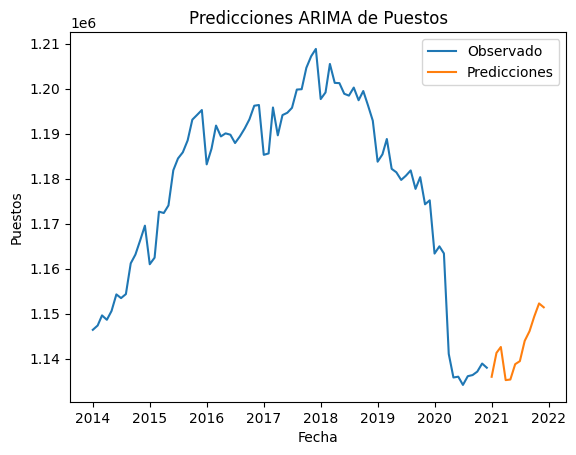

In [63]:

# Realizar predicciones
predictions_arima = arima_fit.predict(start=pd.to_datetime('2021-01-01'), end=pd.to_datetime('2021-12-01')) 


# Visualizar las predicciones
plt.plot(ts, label='Observado')
plt.plot(predictions_arima, label='Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Puestos')
plt.title('Predicciones ARIMA de Puestos')
plt.legend()
plt.show()

In [64]:
# Calculamos el error cuadratico medio
rmse = sqrt(mean_squared_error(test, predictions_arima))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2663.658


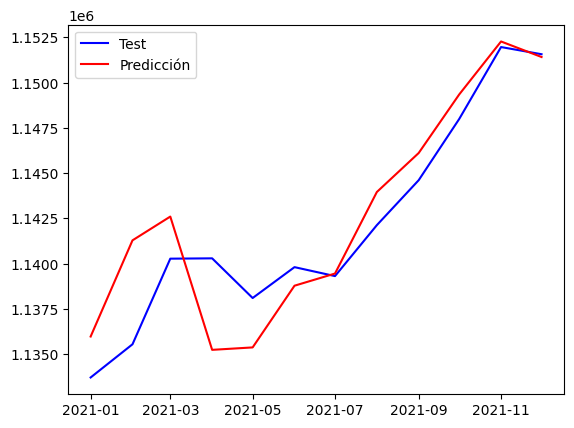

In [65]:
# Generamos un plot de ambas curbas para ver que tan bien estimo el modelo
plt.plot(test, color = "Blue", label = "Test")
plt.plot(predictions_arima, color = "red", label = "Predicción")
plt.legend()
plt.show()

## ARIMAX

In [149]:

dfexo = pd.read_csv("./empleo_nacion/evol_gral_bs_svcios.csv", parse_dates=["fecha"])

In [150]:
# como estoy haciendo muchos cambios genero una copia para no pisar el archivo original
df_exo = dfexo.copy()

# cambiamos el campo fecha de %b-%Y a %Y-%m-%d
df_exo['fecha'] = df_exo['fecha'].apply(lambda x: datetime.strptime(x, "%b-%y").strftime("%Y-%m-%d"))

# cambiamos el campo fecha de str a datetime
df_exo["fecha"] = df_exo.fecha.apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())

In [151]:
df_exo["general_lag"] = df_exo.general.shift(12)

In [152]:
df_exog_test = df_exo.loc[df_exo["fecha"].between(pd.to_datetime("2022-01-01").date() , pd.to_datetime("2022-12-01").date())]

df_exo = df_exo.loc[df_exo["fecha"].between(pd.to_datetime("2014-01-01").date() , pd.to_datetime("2021-12-01").date())]

df_exo.set_index('fecha', inplace=True)

In [164]:
endog = df['puestos']
exog = df_exo['general_lag']
order = (12, 1, 18)

arimax = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog, order=order)
arimax_fit = arimax.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           32     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.96724D+00    |proj g|=  1.00348D+01

At iterate    5    f=  9.82057D+00    |proj g|=  1.49020D-01

At iterate   10    f=  9.80829D+00    |proj g|=  3.73391D+00

At iterate   15    f=  9.75104D+00    |proj g|=  3.06698D+00

At iterate   20    f=  9.74247D+00    |proj g|=  2.58987D-01

At iterate   25    f=  9.73591D+00    |proj g|=  1.31274D+00

At iterate   30    f=  9.66886D+00    |proj g|=  5.83778D+00

At iterate   35    f=  9.65529D+00    |proj g|=  1.14003D+00

At iterate   40    f=  9.64009D+00    |proj g|=  2.23610D+00

At iterate   45    f=  9.60656D+00    |proj g|=  2.38339D+00

At iterate   50    f=  9.57162D+00    |proj g|=  4.90891D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

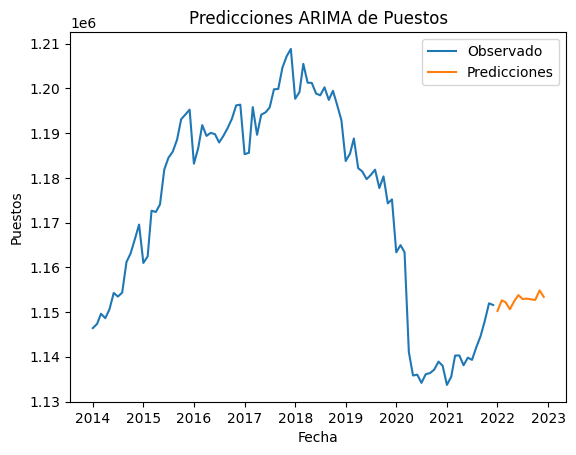

In [165]:
# Realizar predicciones
predictions_arimax = arimax_fit.forecast(steps = 12, exog = df_exog_test.general_lag ) 

# Visualizar las predicciones
plt.plot(ts, label='Observado')
plt.plot(predictions_arimax, label='Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Puestos')
plt.title('Predicciones ARIMA de Puestos')
plt.legend()
plt.show()

In [166]:
# Calculamos el error cuadratico medio
rmse = sqrt(mean_squared_error(test, predictions_arimax))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 4665.460


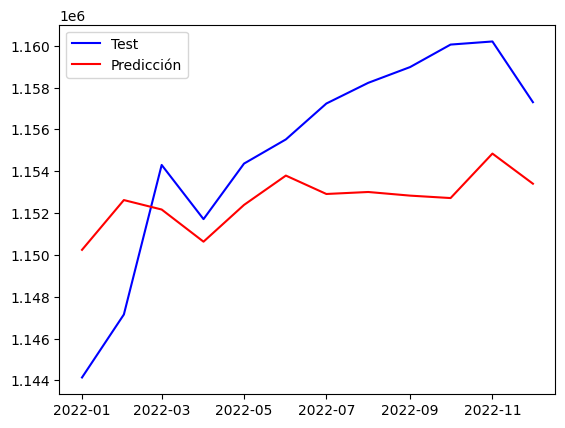

In [167]:

# Generamos un plot de ambas curbas para ver que tan bien estimo el modelo
plt.plot(test, color = "Blue", label = "Test")
plt.plot(predictions_arimax, color = "red", label = "Predicción")
plt.legend()
plt.show()
